# Disease Diagnosis from CXR Images using CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import all packages

In [2]:
import numpy as np
import cv2 as opencv
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, Sequential, layers
import PIL
import pathlib
import os

## Defining Variables

In [3]:
BATCH_SIZE = 2
EPOCHS = 100
IMAGE_SIZE=256

## Tensorflow Data Pipelining

Directory structure is:

main directory/...
...  ATELECTASIS/..
....... images.jpeg
... Cardiomegaly/..
...... images.jpeg
... Consolidation/..
...... images.jpeg
... Edema/..
...... images.jpeg
... No findings/..
...... images.jpeg
...Pleural effusion/..
...... images.jpeg

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
        
        '/content/drive/MyDrive/Colab Notebooks/Training',
        labels='inferred',
        label_mode='int',
        #color_mode='grayscale',
        seed= 123,
        shuffle = True,
        batch_size= BATCH_SIZE,
        image_size=(IMAGE_SIZE,IMAGE_SIZE)
    
)

Found 2014 files belonging to 6 classes.


In [5]:
print(dataset.element_spec)
print(len(dataset))
for i, j in dataset.take(1):
    print(i[0].shape)
    print(j.numpy())

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
1007
(256, 256, 3)
[1 2]


In [6]:
class_names = (dataset.class_names)
class_names

['ATELECTASIS',
 'CARDIOMEGALY',
 'CONSOLIDATION',
 'EDEMA',
 'NO FINDING',
 'PLEURAL EFFUSION']

## Visualizing data Samples

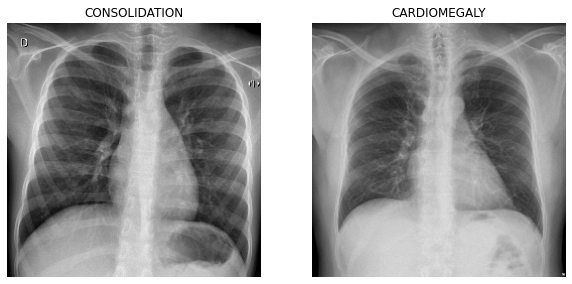

In [8]:
plt.figure(figsize=(10,10))

# visualizing first batch samples
for image, label in dataset.take(1):
    for i in range(2):
        plt.subplot(1,2, i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis('off')



## Splitting Data Set

Since 2000 files found and batch size is 2, so **2000/2 = 1000 batches**

1.   80% Data --> training 
2.   10% data --> validation
1.   10% data --> test


In [9]:
def split_data(ds, train_split = 0.8, val_split=0.1, test_split= 0.1, shuffle_size=10000):
    ds = ds.shuffle(shuffle_size, seed=12)
    total_length = len(ds)
    train_ds = ds.take(int(total_length*train_split))
    validation_ds = ds.skip(int(total_length*train_split)).take(int(total_length * val_split))
    test_ds = ds.skip(int(train_split*total_length)).skip(int(total_length* val_split))
    
    return train_ds, validation_ds, test_ds

In [10]:
train_ds, validation_ds, test_ds = split_data(dataset)

In [11]:
print(len(train_ds))
print(len(validation_ds))
print(len(test_ds))

805
100
102


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the model

### Resizing and reshaping layer

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(scale= 1./255)

])

**using CNN Architecture**

In [14]:
shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, 3)
output_classes= 6

model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(filters=2, kernel_size=(3,3),padding='same', activation='relu', input_shape=shape),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(.2),
        layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(.2),
        layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(.2),
        layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(.2),
        layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_classes, activation='softmax'),
    

])
model.build((BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))

In [15]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (2, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (2, 256, 256, 2)          56        
                                                                 
 max_pooling2d (MaxPooling2D  (2, 128, 128, 2)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (2, 128, 128, 2)          0         
                                                                 
 conv2d_1 (Conv2D)           (2, 128, 128, 32)         608       
                                                                 
 max_pooling2d_1 (MaxPooling  (2, 64, 64, 32)          0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=validation_ds,
    verbose=1,
    epochs=100
)

Epoch 1/100
805/805 [==============================] - 308s 32ms/step - loss: 1.6846 - accuracy: 0.1975 - val_loss: 1.6957 - val_accuracy: 0.2200
Epoch 2/100
805/805 [==============================] - 5s 7ms/step - loss: 1.6626 - accuracy: 0.1851 - val_loss: 1.6792 - val_accuracy: 0.2700
Epoch 3/100
805/805 [==============================] - 5s 6ms/step - loss: 1.6369 - accuracy: 0.2745 - val_loss: 1.6279 - val_accuracy: 0.2700
Epoch 4/100
805/805 [==============================] - 5s 6ms/step - loss: 1.5814 - accuracy: 0.3124 - val_loss: 1.5939 - val_accuracy: 0.3200
Epoch 5/100
805/805 [==============================] - 5s 6ms/step - loss: 1.5385 - accuracy: 0.3366 - val_loss: 1.5630 - val_accuracy: 0.3200
Epoch 6/100
805/805 [==============================] - 5s 6ms/step - loss: 1.5178 - accuracy: 0.3565 - val_loss: 1.5404 - val_accuracy: 0.3750
Epoch 7/100
805/805 [==============================] - 6s 7ms/step - loss: 1.4644 - accuracy: 0.3832 - val_loss: 1.4643 - val_accuracy: 0.4

In [18]:
# Check loss value and accuracy on unseen test data
output = model.evaluate(test_ds)

102/102 [==============================] - 12s 4ms/step - loss: 0.9916 - accuracy: 0.6422


In [ ]:
output

[0.9589341282844543, 0.6683168411254883]

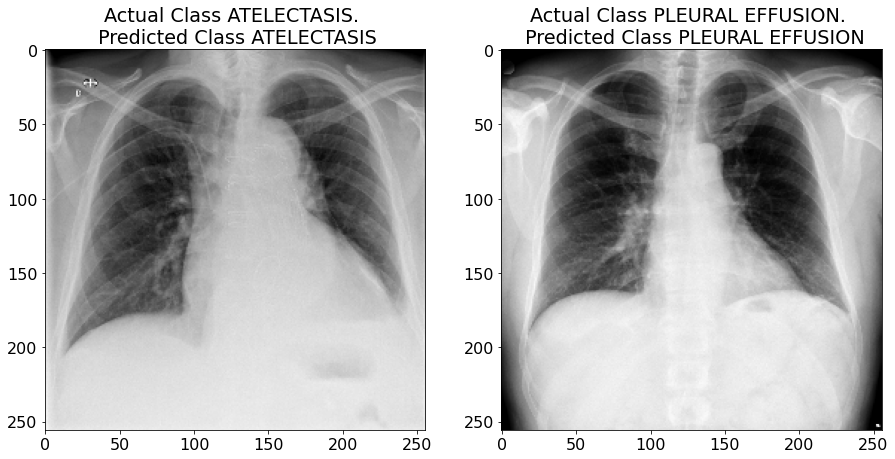

In [ ]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(1):
  
    for i in range(2):
      image = images_batch[i].numpy().astype('uint8')
      label = labels_batch[i].numpy()
      plt.subplot(1, 2, i+1)
      plt.imshow(image)
      batch_prediction = model.predict(images_batch)
      plt.title(f'Actual Class {class_names[label]}. \n Predicted Class {class_names[np.argmax(batch_prediction[i])]}' )

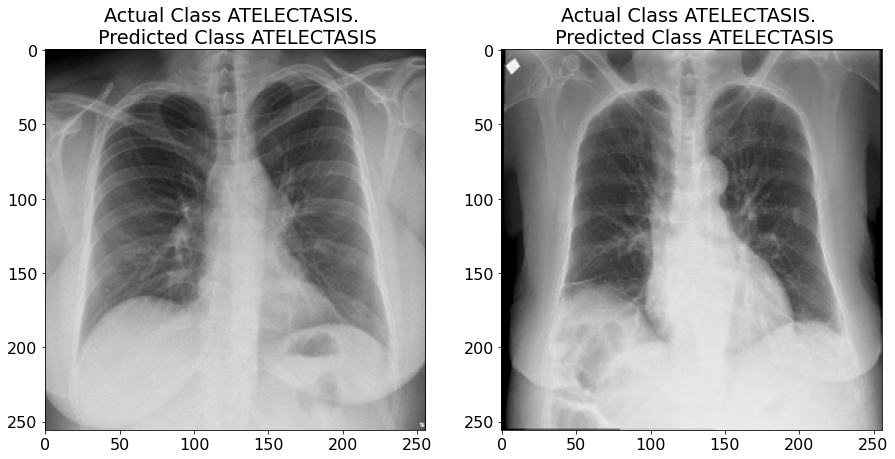

In [ ]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(3).skip(2):
  
    for i in range(2):
      image = images_batch[i].numpy().astype('uint8')
      label = labels_batch[i].numpy()
      plt.subplot(1, 2, i+1)
      plt.imshow(image)
      batch_prediction = model.predict(images_batch)
      plt.title(f'Actual Class {class_names[label]}. \n Predicted Class {class_names[np.argmax(batch_prediction[i])]}' )

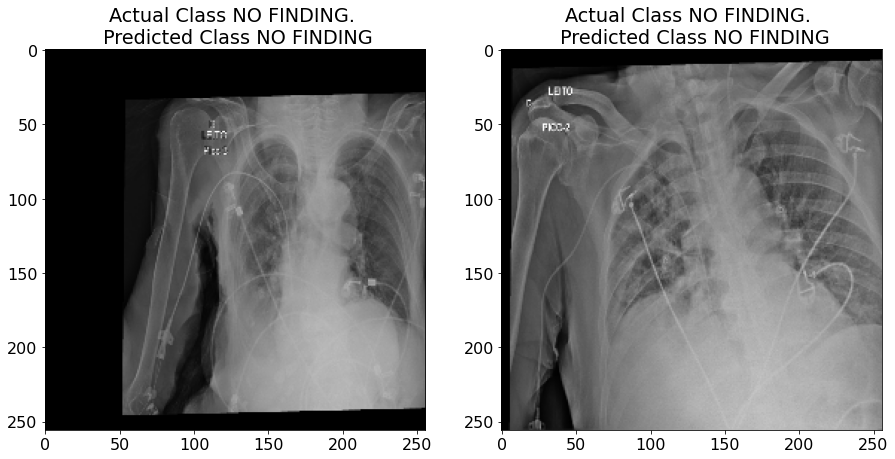

In [ ]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(4).skip(3):
  
    for i in range(2):
      image = images_batch[i].numpy().astype('uint8')
      label = labels_batch[i].numpy()
      plt.subplot(1, 2, i+1)
      plt.imshow(image)
      batch_prediction = model.predict(images_batch)
      plt.title(f'Actual Class {class_names[label]}. \n Predicted Class {class_names[np.argmax(batch_prediction[i])]}' )

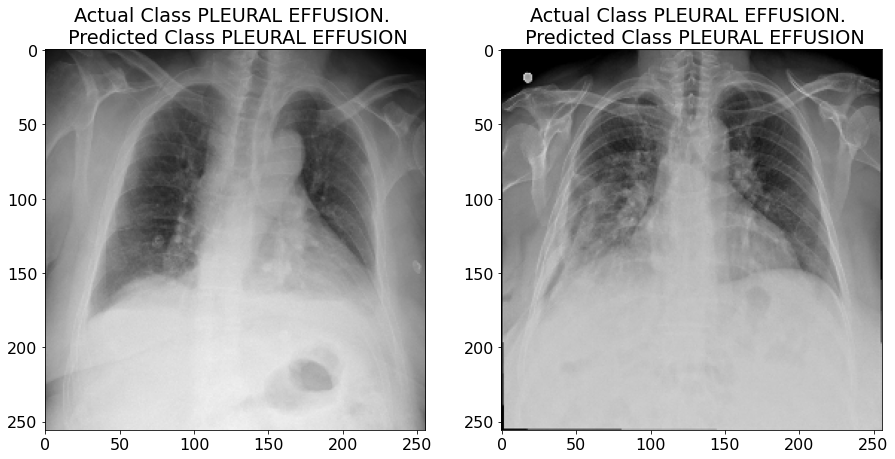

In [ ]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(6).skip(5):
  
    for i in range(2):
      image = images_batch[i].numpy().astype('uint8')
      label = labels_batch[i].numpy()
      plt.subplot(1, 2, i+1)
      plt.imshow(image)
      batch_prediction = model.predict(images_batch)
      plt.title(f'Actual Class {class_names[label]}. \n Predicted Class {class_names[np.argmax(batch_prediction[i])]}' )

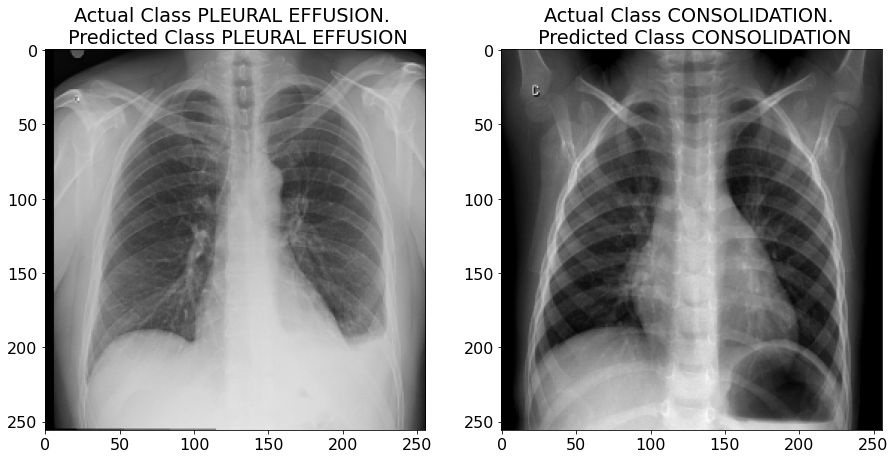

In [ ]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(25).skip(24):
  
    for i in range(2):
      image = images_batch[i].numpy().astype('uint8')
      label = labels_batch[i].numpy()
      plt.subplot(1, 2, i+1)
      plt.imshow(image)
      batch_prediction = model.predict(images_batch)
      plt.title(f'Actual Class {class_names[label]}. \n Predicted Class {class_names[np.argmax(batch_prediction[i])]}' )

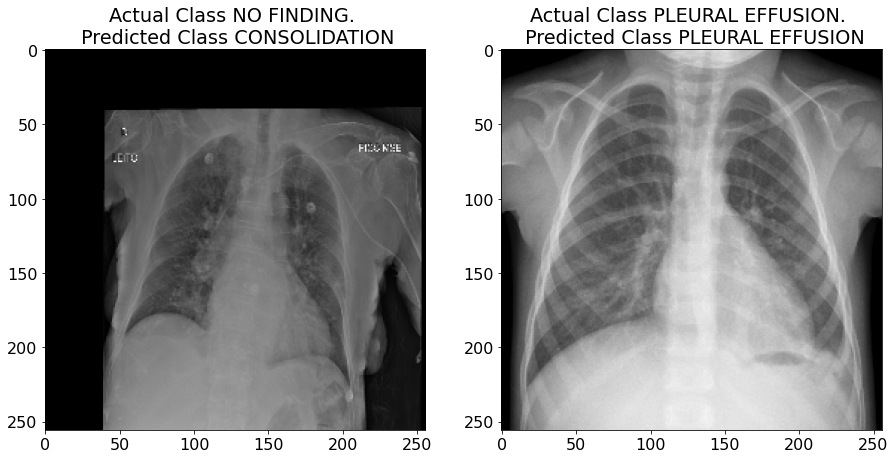

In [ ]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(30).skip(29):
  
    for i in range(2):
      image = images_batch[i].numpy().astype('uint8')
      label = labels_batch[i].numpy()
      plt.subplot(1, 2, i+1)
      plt.imshow(image)
      batch_prediction = model.predict(images_batch)
      plt.title(f'Actual Class {class_names[label]}. \n Predicted Class {class_names[np.argmax(batch_prediction[i])]}' )

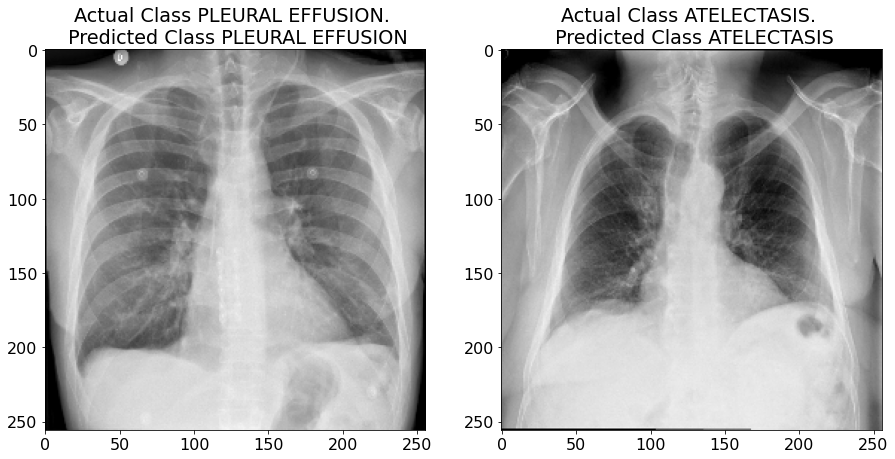

In [ ]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(55).skip(54):
  
    for i in range(2):
      image = images_batch[i].numpy().astype('uint8')
      label = labels_batch[i].numpy()
      plt.subplot(1, 2, i+1)
      plt.imshow(image)
      batch_prediction = model.predict(images_batch)
      plt.title(f'Actual Class {class_names[label]}. \n Predicted Class {class_names[np.argmax(batch_prediction[i])]}' )

**Model Visual Representation**

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

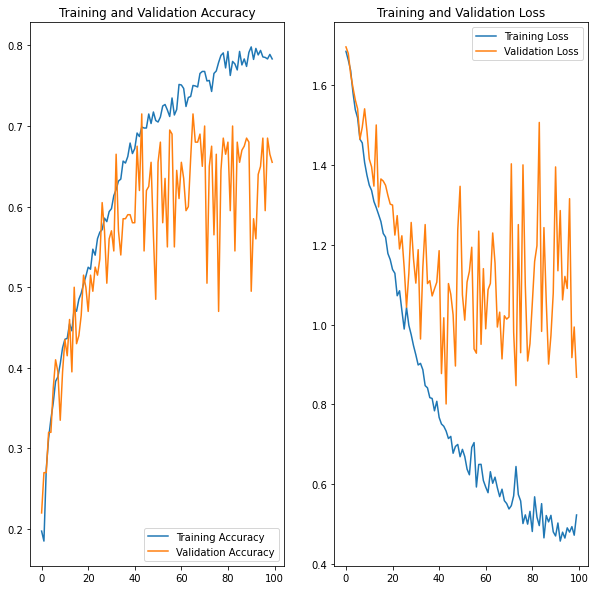

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Confusion Matrix**

<Figure size 720x720 with 0 Axes>

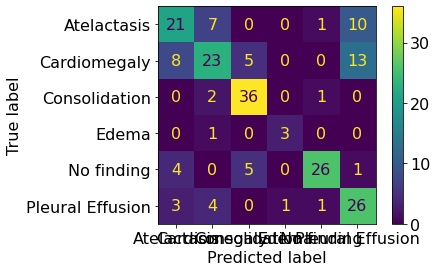

In [ ]:
plt.figure(figsize=(10,10))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Take all labels of test data
temp = []
pred_y=[]
for x, y in test_ds.take(101):
  y1 = y[0].numpy()
  y2 = y[1].numpy()
  temp.append(y1)
  temp.append(y2)
  lab = model.predict(x)
  l0 = np.argmax(lab[0])
  l1 = np.argmax(lab[1])
  pred_y.append(l0)
  pred_y.append(l1)

cmd = ConfusionMatrixDisplay((confusion_matrix(temp, pred_y)), display_labels=['Atelactasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'No finding', 'Pleural Effusion'])
cmd.plot()

plt.show()
